In [65]:
# install dependencies
! pip install pandas
! pip3 install torch --index-url https://download.pytorch.org/whl/cu128
! pip install ipdb
! pip install tqdm
! pip install pyarrow
! pip install matplotlib
! pip install scikit-learn


Looking in indexes: https://download.pytorch.org/whl/cu128
  Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.2-cp313-cp313-win_amd64.whl (223 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   --------------------------- ------------ 1.6/2.2 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 6.6 MB/s eta 0:00:00
Using cached kiwisolver-1.4.8-cp313-cp313-win_amd64.whl (71 kB)
   ---------------------------------------- 0.0

In [1]:
# import libraries
import os
#os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import pandas as pd
import glob
import torch
from torch.utils.data import Dataset, DataLoader, random_split, IterableDataset
import gc
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import time
from tqdm import tqdm
import pyarrow.dataset as ds
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# ! cp drive/MyDrive/normalized-ids2018-parquet.tar.gz /content/
! tar -xzvf normalized-ids2018-parquet.tar.gz normalized/

In [2]:
PARQUET_FILES = glob.glob('normalized/*')

In [3]:
# canon columns
CANON_COLUMN_INDEX = ['Fwd IAT Tot', 'Fwd Pkt Len Min', 'Down/Up Ratio', 'Dst Port', 'Fwd IAT Std', 'Fwd Header Len', 'Fwd IAT Min', 'Flow IAT Std', 'Active Std', 'Bwd IAT Max', 'Fwd Pkt Len Mean', 'Pkt Size Avg', 'PSH Flag Cnt', 'Flow IAT Mean', 'Fwd Act Data Pkts', 'Bwd Pkt Len Max', 'Flow IAT Max', 'ACK Flag Cnt', 'Bwd IAT Tot', 'Flow IAT Min', 'Bwd Pkts/b Avg', 'Fwd IAT Max', 'SYN Flag Cnt', 'Bwd Header Len', 'Fwd Seg Size Avg', 'Bwd Byts/b Avg', 'Subflow Bwd Byts', 'Pkt Len Max', 'Bwd Pkts/s', 'Fwd IAT Mean', 'Pkt Len Var', 'Fwd Pkt Len Std', 'Protocol', 'Init Bwd Win Byts', 'Active Min', 'Src Port', 'RST Flag Cnt', 'Subflow Fwd Byts', 'Init Fwd Win Byts', 'Bwd Pkt Len Std', 'Fwd PSH Flags', 'Fwd Pkts/s', 'Bwd Blk Rate Avg', 'Flow Byts/s', 'CWE Flag Count', 'Pkt Len Std', 'Active Max', 'Fwd Byts/b Avg', 'Fwd Blk Rate Avg', 'URG Flag Cnt', 'Timestamp', 'Fwd Pkts/b Avg', 'Idle Mean', 'Idle Std', 'Fwd Pkt Len Max', 'Pkt Len Min', 'Flow Duration', 'Fwd Seg Size Min', 'Bwd IAT Min', 'TotLen Fwd Pkts', 'Flow Pkts/s', 'Active Mean', 'ECE Flag Cnt', 'Idle Min', 'Subflow Bwd Pkts', 'Bwd Pkt Len Mean', 'Pkt Len Mean', 'Tot Fwd Pkts', 'Bwd IAT Std', 'Bwd Seg Size Avg', 'Bwd URG Flags', 'Bwd Pkt Len Min', 'Tot Bwd Pkts', 'Subflow Fwd Pkts', 'Bwd IAT Mean', 'FIN Flag Cnt', 'Bwd PSH Flags', 'TotLen Bwd Pkts', 'Fwd URG Flags', 'Idle Max']
CANON_COLUMN_INDEX.sort()
CANON_COLUMN_INDEX.append('Label')
print(CANON_COLUMN_INDEX)
TRAINING_UNWANTED_COLUMNS = ['Timestamp', 'Flow ID', 'Dst IP', "Src IP"]
TRAINING_WANTED_COLUMNS = []
for col in CANON_COLUMN_INDEX:
  if col not in TRAINING_UNWANTED_COLUMNS:
    TRAINING_WANTED_COLUMNS.append(col)
print(TRAINING_WANTED_COLUMNS)
TRAINING_FEATURES = TRAINING_WANTED_COLUMNS[:-1]

LENGTH = 16233002 # precalculated from data wrangling, see info.json


['ACK Flag Cnt', 'Active Max', 'Active Mean', 'Active Min', 'Active Std', 'Bwd Blk Rate Avg', 'Bwd Byts/b Avg', 'Bwd Header Len', 'Bwd IAT Max', 'Bwd IAT Mean', 'Bwd IAT Min', 'Bwd IAT Std', 'Bwd IAT Tot', 'Bwd PSH Flags', 'Bwd Pkt Len Max', 'Bwd Pkt Len Mean', 'Bwd Pkt Len Min', 'Bwd Pkt Len Std', 'Bwd Pkts/b Avg', 'Bwd Pkts/s', 'Bwd Seg Size Avg', 'Bwd URG Flags', 'CWE Flag Count', 'Down/Up Ratio', 'Dst Port', 'ECE Flag Cnt', 'FIN Flag Cnt', 'Flow Byts/s', 'Flow Duration', 'Flow IAT Max', 'Flow IAT Mean', 'Flow IAT Min', 'Flow IAT Std', 'Flow Pkts/s', 'Fwd Act Data Pkts', 'Fwd Blk Rate Avg', 'Fwd Byts/b Avg', 'Fwd Header Len', 'Fwd IAT Max', 'Fwd IAT Mean', 'Fwd IAT Min', 'Fwd IAT Std', 'Fwd IAT Tot', 'Fwd PSH Flags', 'Fwd Pkt Len Max', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Min', 'Fwd Pkt Len Std', 'Fwd Pkts/b Avg', 'Fwd Pkts/s', 'Fwd Seg Size Avg', 'Fwd Seg Size Min', 'Fwd URG Flags', 'Idle Max', 'Idle Mean', 'Idle Min', 'Idle Std', 'Init Bwd Win Byts', 'Init Fwd Win Byts', 'PSH Flag Cnt

In [ ]:
# pyarrow parquet dataset
class ArrowParquetDataset(IterableDataset):
    def __init__(self, path, batch_size=1024, shuffle=False):
        self.path = path
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.num_iterations = int(LENGTH / self.batch_size)

    def __iter__(self):
        dataset = ds.dataset(self.path, format="parquet")
        scanner = dataset.scanner(columns=TRAINING_WANTED_COLUMNS, batch_size=self.batch_size)
        batches = scanner.to_batches()

        if self.shuffle:
            # Convert to list and shuffle batches if needed
            batches = list(batches)
            random.shuffle(batches)

        for batch in batches:
            x = batch.select(TRAINING_FEATURES).to_tensor(null_to_nan=True)
            y_string_array = batch.column("Label")

            # Optional: convert to torch.Tensor
            x = torch.tensor(x, dtype=torch.float32)
            y = torch.tensor([(0.0 if val.as_py() == "Benign" else 1.0) for val in y_string_array], dtype=torch.float32)

            # mask and impute nans
            mask = torch.isnan(x).float()
            x = torch.nan_to_num(x, nan=0.0)
            x = torch.cat([x, mask], dim=1)

            yield x, y

DS_ARROW = ArrowParquetDataset(PARQUET_FILES, batch_size=1024)

In [ ]:
# create dataset
class IDS2018Dataset(Dataset):
  def __init__(self, files):
    self.files = files
    self.idx_map = []
    self.curr_file = -1
    self.curr_df = None
    self.length = 0

    self.calcIdxMap()
    self.loadCSV(0)

  def loadCSV(self, file_idx):
    if self.curr_file == file_idx:
      return

    if self.curr_file != -1:
      del self.curr_df
      gc.collect()

    df = pd.read_parquet(self.files[file_idx])
    df = df.reindex(columns=CANON_COLUMN_INDEX)
    for col in df.columns:
      if col in TRAINING_UNWANTED_COLUMNS:
        df = df.drop(columns=[col])

    self.curf_file = file_idx
    self.curr_df = df

  def calcIdxMap(self):
    for i, file in enumerate(self.files):
      df = pd.read_parquet(file)
      self.idx_map.extend([(i, j) for j in range(len(df))])
    self.length = len(self.idx_map)

  def __len__(self):
    return self.length

  def __getitem__(self, idx):
    file_idx, row_idx = self.idx_map[idx]

    if file_idx != self.curr_file:
      self.loadCSV(file_idx)

    data = self.curr_df.loc[row_idx]

    x = torch.tensor(data.iloc[0:-1].values.astype(np.float32), dtype=torch.float32)
    y = torch.tensor((0.0 if data.iloc[-1] == "Benign" else 1.0), dtype=torch.float32)

    # mask and impute nans
    mask = torch.isnan(x).float()
    x = torch.nan_to_num(x, nan=0.0)
    x = torch.cat([x, mask])

    return x,y

DS_CLASSIC = IDS2018Dataset(PARQUET_FILES)
print(DS_CLASSIC[0][0].size())

torch.Size([158])


In [8]:
# split datasets and make loaders
TRAIN_DS, TEST_DS = random_split(DS_CLASSIC, [0.8, 0.2])
train_loader = DataLoader(TRAIN_DS, batch_size=64, shuffle=False)
test_loader = DataLoader(TEST_DS, batch_size=64, shuffle=False)

NameError: name 'DS_CLASSIC' is not defined

In [5]:
# create model
class DNN(nn.Module):
  def __init__(self, input_size, hidden_sizes, output_size):
    super(DNN, self).__init__()

    #layers
    self.input = nn.Linear(input_size, hidden_sizes[0])
    self.output = nn.Linear(hidden_sizes[-1], output_size)
    self.hiddens = nn.ModuleList()
    for i in range(len(hidden_sizes) - 1):
      self.hiddens.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

  def forward(self, x):
    x = F.relu(self.input(x))
    for layer in self.hiddens:
      x = F.relu(layer(x))

    x = self.output(x)
    return torch.sigmoid(x).view(-1)


In [6]:
# create model
input_shape = len(TRAINING_FEATURES)
model = DNN(input_shape * 2, # because masking
                [int(input_shape / 2), int(input_shape / 4)],
                1)
print(model)

DNN(
  (input): Linear(in_features=158, out_features=39, bias=True)
  (output): Linear(in_features=19, out_features=1, bias=True)
  (hiddens): ModuleList(
    (0): Linear(in_features=39, out_features=19, bias=True)
  )
)


In [ ]:
# train
torch.cuda.empty_cache()

model.to(device)
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999))
epochs = 10

historical_loss = []

train_start_time = time.time()
for epoch in range(epochs):
  model.train()
  epoch_loss = 0.0

  epoch_samples = 0
  for x, y in tqdm(DS_ARROW, total=DS_ARROW.num_iterations):
    x = x.to(device)
    y = y.to(device)

    optim.zero_grad()
    out = model(x)
    loss = loss_fn(out, y)
    loss.backward()
    optim.step()
    epoch_loss += loss.item()

  epoch_loss = epoch_loss / DS_ARROW.num_iterations
  historical_loss.append(epoch_loss)
  print(f'epoch: {epoch + 1}/{epochs}, loss: {epoch_loss:.4f}')
min, sec = divmod(int(time.time() - train_start_time), 60)
print(f'train time: {min}:{sec}')

15857it [01:26, 183.01it/s]                           


epoch: 1/10, loss: 0.0613


15857it [01:23, 190.03it/s]                           


epoch: 2/10, loss: 0.0527


15857it [01:30, 174.93it/s]                           


epoch: 3/10, loss: 0.0474


15857it [01:28, 180.13it/s]                           


epoch: 4/10, loss: 0.0522


15857it [01:34, 167.43it/s]                           


epoch: 5/10, loss: 0.0568


15857it [01:35, 165.60it/s]                           


epoch: 6/10, loss: 0.0449


15857it [01:34, 168.42it/s]                           


epoch: 7/10, loss: 0.0458


15857it [01:34, 168.10it/s]                           


epoch: 8/10, loss: 0.0442


15857it [01:33, 168.93it/s]                           


epoch: 9/10, loss: 0.0602


15857it [01:34, 168.07it/s]                           


epoch: 10/10, loss: 0.0609


ValueError: Precision not allowed in integer format specifier

In [ ]:
# test
model.eval()
test_loss = 0.0
test_start_time = time.time()

historical_label = []
historical_pred = []

with torch.no_grad():
  for x, y in tqdm(DS_ARROW, total=DS_ARROW.num_iterations):
    x = x.to(device)
    y = y.to(device)

    out = model(x)
    test_loss += loss_fn(out, y).item()

    if random.random() < 0.001:
      historical_label.append(y.to("cpu"))
      historical_pred.append(out.to("cpu"))

test_loss = test_loss / DS_ARROW.num_iterations
print(f'loss: {test_loss:.4f}')
min, sec = divmod(int(time.time() - train_start_time), 60)
print(f'train time: {min}:{sec:.2d}')

15857it [01:04, 245.02it/s]                           


ValueError: Precision not allowed in integer format specifier

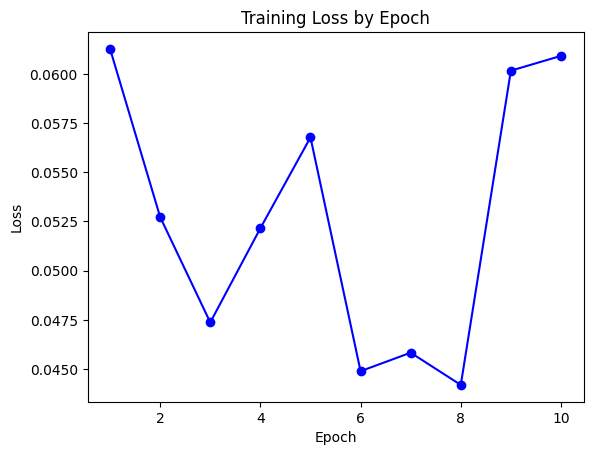

C:\Users\imlam\AppData\Local\Temp\ipykernel_11384\2340117585.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  thresholds = np.array(thresholds)


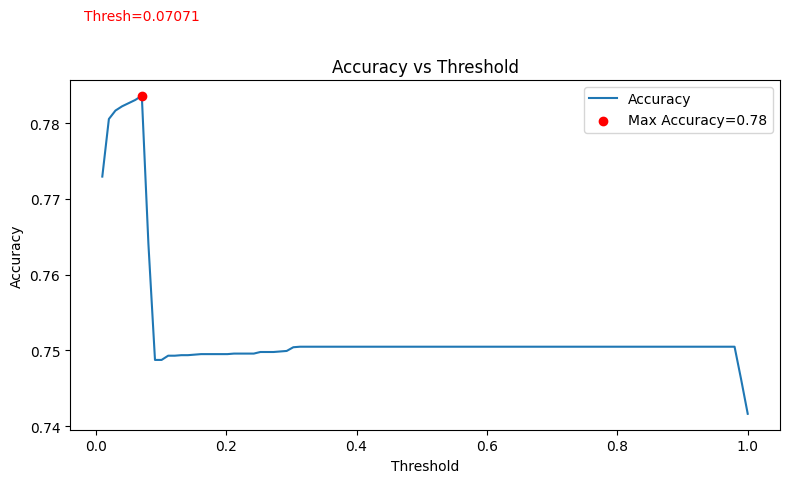

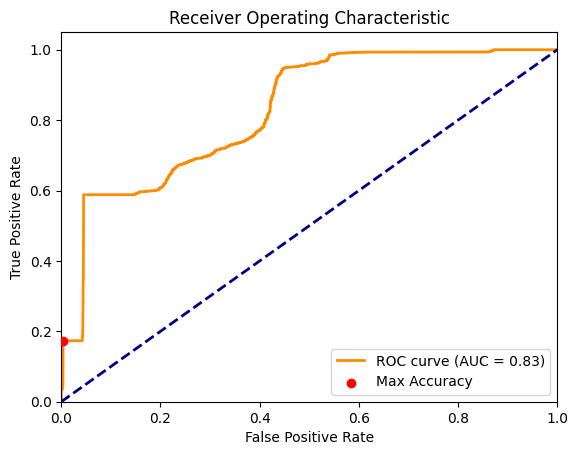

In [25]:
# analyze

# historical_pred = torch.cat(historical_pred).tolist()
# historical_label = torch.cat(historical_label).tolist()

# epoch loss
plt.figure()
plt.plot(range(1, epochs + 1), historical_loss, marker='o', color='blue')
plt.title('Training Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# accuracy
def accuracy_at_threshold(y_scores, y_true, threshold):
    y_pred = (y_scores >= threshold).float()
    correct = (y_pred == y_true).sum().item()
    return correct / len(y_true)

thresh_steps = 100
thresholds = torch.linspace(0, 1, steps=thresh_steps)
accuracies = []
for t in thresholds: 
    correct = 0
    for i in range(len(historical_label)):
        if (historical_pred[i] > t and historical_label[i] > 0.5) or \
        (historical_pred[i] < t and historical_label[i] < 0.5):
            correct += 1

    accuracies.append(correct / len(historical_label))

thresholds = np.array(thresholds)
accuracies = np.array(accuracies)
max_idx = np.argmax(accuracies)
best_thresh = thresholds[max_idx]
best_acc = accuracies[max_idx]

plt.figure(figsize=(8, 5))
plt.plot(thresholds[1:], accuracies[1:], label='Accuracy')
plt.scatter([best_thresh], [best_acc], color='red', zorder=5, label=f'Max Accuracy={best_acc:.2f}')
plt.text(best_thresh, best_acc + 0.01, f'Thresh={best_thresh:.5f}', ha='center', color='red')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Threshold')
plt.legend()
plt.tight_layout()
plt.show()

# roc and auc
fpr, tpr, thresholds_roc = roc_curve(historical_label, historical_pred)
roc_auc = auc(fpr, tpr)

for i in range(len(thresholds_roc)):
    if thresholds_roc[i] <= (best_thresh + (1/thresh_steps)) and \
    thresholds_roc[i] >= (best_thresh - (1/thresh_steps)):
        best_fpr = fpr[i]
        best_tpr = tpr[i]
        break

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.scatter([best_fpr], [best_tpr], color='red', zorder=5, label=f'Max Accuracy')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()